# Noise reduction
NOTE: As of 8. September 2023, we are hoping for a fix of the HTML-ipywidget problems showing up in the compiled JupyterBook.  
- Noise reduction is typically the process of estimating and removing/reducing noise in a time series or spectrum.
    - Measured wind speed: Average wind (over a suitably small time interval) may be more interesting than every little whirl and change.
    - Master thesis on nuclear reactor cracks: 15 second resoultion gives uninteresting variations in the micrometer scale signal.
    - Instruments have a limit to their certified sensitivity: Smoothing sub-sensitivity can make sense.
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) and [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) have wide ranges of possibilites.
- At this stage the general assumption is that noise is uninformative, thus can be removed without harming the signal.
- Signal-to-noise is a ratio that can be caulculated in various ways.
    - A measure of how easy it is to extract the underlying information.

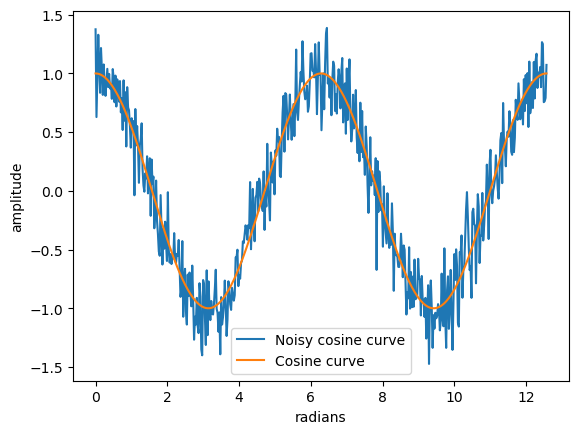

In [1]:
# Plot a cosine curve from 0 to 3pi
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 4*np.pi, 500)
y_cos = np.cos(x)

# Add noise to the curve
noise = 0.2*np.random.normal(size=(len(x)))
plt.plot(x, y_cos+noise, label='Noisy cosine curve')
plt.plot(x, y_cos, label='Cosine curve')
plt.xlabel('radians')
plt.ylabel('amplitude')
plt.legend()
plt.show()

## Signal-to-Noise Ratio (SNR)
- A common definition is decibel (dB) based.
    - 0 decibel means the signal and noise are of equal magnitude.
    - Every 10 decibel increase means 10 times higher power of the signal compared to the noise.
- $SNR = 10 \cdot log_{10} \frac{\sum s_i^2}{\sum n_i^2}$, where $s$ is the signal and $n$ is the noise.

In [2]:
def SNR(signal, noise):
    return 10*np.log10(np.sum(signal**2)/np.sum(noise**2))

## Moving average
- A window of length _n_ slides along the measured values.
    - Compute the average value of the window
    - Replace the central value.
- One of the simplest approaches available.
- Useable on streaming data:
    - No learning, lag equal to window width.
- Can be tuned:
    - Width of the window.
    - Weighted average, e.g., more weight on the central values.
    - Median instead of mean.
    - Replace the last value instead of the middle value (maybe using different weights).

### Simple moving average
An efficient alterantive can be found in the [Uniform 1D filter from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html).
- Handles edge effects - which values to where the window doesn't fit?
- Can set which value to replace.

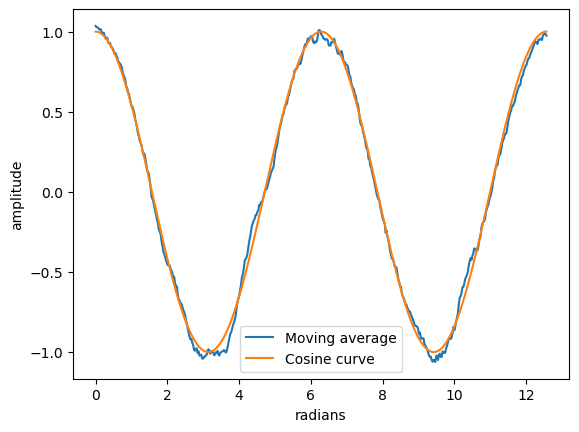

SNR: 24.54 dB


In [3]:
# Apply a simple moving average filter using uniform_filter1d
from scipy.ndimage import uniform_filter1d
y_sma = uniform_filter1d(y_cos+noise, size=20) # Note that 'size' refers to number of values, not x-axis units
plt.plot(x, y_sma, label='Moving average')
plt.plot(x, y_cos, label='Cosine curve')
plt.xlabel('radians')
plt.ylabel('amplitude')
plt.legend()
plt.show()
print('SNR: {:.2f} dB'.format(SNR(y_cos, y_cos-y_sma)))

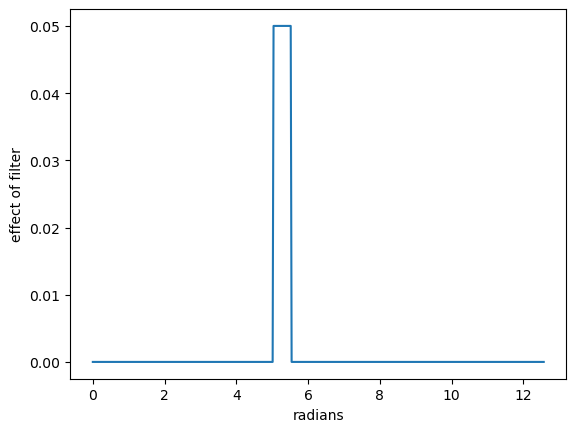

In [4]:
# The filter affects only locally
x = np.linspace(0, 4*np.pi, 500)
z = np.zeros(len(x))
z[200:220] = 1/20 # Filter of width 20 at position 210
plt.plot(x, z)
plt.xlabel('radians')
plt.ylabel('effect of filter')
plt.rcParams['figure.figsize'] = [5, 4]
plt.show()

### Adding GUI controls
- [_ipywidgets_](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) is one way of adding controls to a plot.
- Wrap your plot in a function, give the function as input to interact together with tuples, Booleans, strings, etc. to automatically generate GUI elements.

In [5]:
# Use ipywidgets to interactively change the size of the filter
from ipywidgets import interact
def plot_sma(size):
    y_sma = uniform_filter1d(y_cos+noise, size=size)
    plt.plot(x, y_sma, label='Moving average')
    plt.plot(x, y_cos, label='Cosine curve')
    plt.xlabel('radians')
    plt.ylabel('amplitude')
    plt.legend()
    plt.title('SNR: {:.2f} dB'.format(SNR(y_cos, y_cos-y_sma)))
    plt.show()
interact(plot_sma, size=(1, 100, 1))


interactive(children=(IntSlider(value=50, description='size', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_sma(size)>

### Exercise
1. Modify the interactive code to include choice of edge effect handling.
2. Modify further to choose between first, middle and last point in the window for origin (replaced value).

## Robustifying
- Instead of a simple average, one can use robust statistics.
- Median filter - less affected by outliers, but results in a more jagged curve (medians typically change less frequently along a curve). ([medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html) and [median_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html))
- Robust mean filter - remove outer 5/10/20\% of samples in the window.

In [6]:
# Robust mean, play with last value in the array
m = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20])
np.mean(m[(m > np.percentile(m, 5)) & (m < np.percentile(m, 95))])

5.0

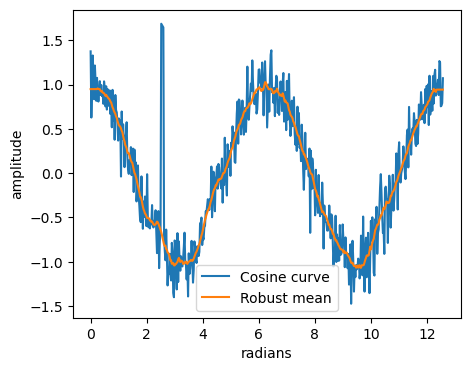

SNR: 22.61 dB


In [7]:
# Create a function that calculates the robust mean in local windows (no optimisation of speed here)
def robust_mean(x, percentile=5):
    return np.mean(x[(x > np.percentile(x, percentile)) & (x < np.percentile(x, 100-percentile))])
def robust_mean_filter1d(x, filter_size, percentile):
    tmp = np.array([robust_mean(x[i:i+filter_size], percentile=percentile) for i in range(len(x)-filter_size+1)])
    return np.concatenate((np.repeat(tmp[1], np.floor(filter_size/2)), tmp, np.repeat(tmp[-1], np.ceil(filter_size/2)-1)))

# Add five consecutive extreme values to the cosine curve
# Example could be ice cream sales in the differente seasons with a new ice cream flavour coming out
noise2 = noise.copy()
noise2[100:104] = 2.5

# Play with percentile and filter_size
y_rmean = robust_mean_filter1d(y_cos+noise2, filter_size=20, percentile=20)
plt.plot(x, y_cos+noise2, label='Cosine curve')
plt.plot(x, y_rmean, label='Robust mean')
plt.xlabel('radians')
plt.ylabel('amplitude')
plt.legend()
plt.show()
print('SNR: {:.2f} dB'.format(SNR(y_cos, y_cos-y_rmean)))

### Gaussian weighting
- Use a normal distribution to weight the interval.
- [SciPy's Gaussian 1D filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html#scipy.ndimage.gaussian_filter1d) has several parameters (in addition to edge mode), but most important is:
    - _sigma_: the standard deviation of the kernel.
- SciPy's default is to cut the filter at +/- 4\*sigma

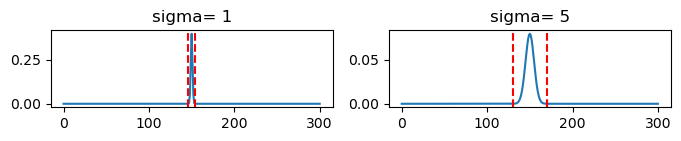

In [8]:
import numpy as np
import matplotlib.pyplot as plt

sigma1 = 1
sigma2 = 5

def gaussian(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    # The normal distribution in 1D
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

# Plot the filters
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 1)
ax[0].plot(gaussian(size=301,sigma=sigma1))
ax[0].axvline(x=150-4*sigma1, color='r', linestyle='--')
ax[0].axvline(x=150+4*sigma1, color='r', linestyle='--')
ax[0].set_title(f'sigma= {sigma1}')
ax[1].plot(gaussian(size=301,sigma=sigma2))
ax[1].axvline(x=150-4*sigma2, color='r', linestyle='--')
ax[1].axvline(x=150+4*sigma2, color='r', linestyle='--')
ax[1].set_title(f'sigma= {sigma2}')
plt.show()

In [9]:
from scipy.ndimage import gaussian_filter1d
# New data for a change.
# Here, we do not know the true underlying signal, so SNR is not calculated
rng = np.random.default_rng(0)
y = rng.standard_normal(301).cumsum()

def plot_gauss(sigma, show_window, position):
    y_gauss = gaussian_filter1d(y, sigma=sigma)
    plt.plot(y, label='Random curve')
    plt.plot(y_gauss, label='Gaussian filtered curve')
    if show_window:
        plt.axvspan(position-round(4*sigma), position+round(4*sigma), color='red', alpha=0.2, label='Filter window')
    plt.xlabel('arbitrary units')
    plt.ylabel('amplitude')
    plt.legend()
    plt.show()
interact(plot_gauss, sigma=(0.1, 10, 0.1), show_window=True, position=(30, 270, 1))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.1), Checkbox(value=True, des…

<function __main__.plot_gauss(sigma, show_window, position)>

## Savitzky-Golay filters
- [Savitzky and Golay in 1964](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) made a sliding window smoothing filter using local polynomial fitting.
    - Smoothing parameters: 
        - Window length/size/width: typically an odd number from 3 up to length of spectrum.
        - Polynomial order: less than window length, typically 2 or 3.
- Combined with discrete derivatives it produces smoothed derivative curves.
    - Popular in spectroscopy, enhances certain characteristics of chemical variation.
    - Second derivative popular for its baseline removal effect.
    - Derivative parameter: Degree of derivative, non-negative integer.
- Edge effects have different defaults from software to software.

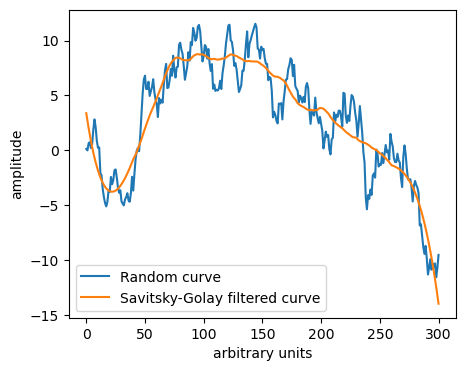

In [10]:
# Savitsky-Golay filter
from scipy.signal import savgol_filter # savgol_choeffs shows the coefficients used
y_sg = savgol_filter(y, 81, 3) # window size 81, polynomial order 3

# Plot the results
plt.plot(y, label='Random curve')
plt.plot(y_sg, label='Savitsky-Golay filtered curve')
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.legend()
plt.show()

### Smoothed signal or residual
- Some times we may use a smoother to remove a trend.
- This can be thought of as a high-pass filter (allowing only high frequencies).

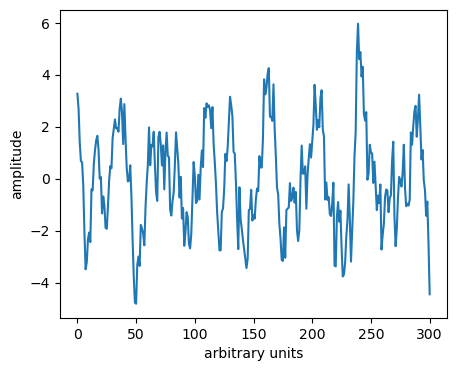

In [11]:
# Plot the difference between the two curves
plt.plot(y_sg-y)
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.show()

### Derivatives
- A smoothed derivative shows the trend of the data series rather than the absolute value.

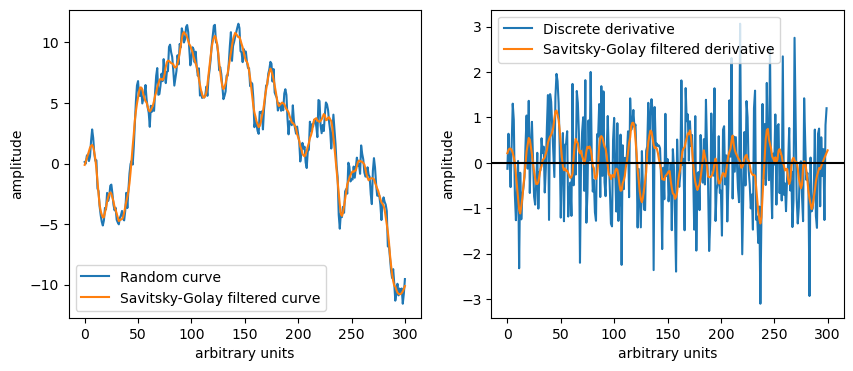

In [12]:
y_sg = savgol_filter(y, 15, 3) # window size 15, polynomial order 3
yderiv = savgol_filter(y, 15, 3, 1) # window size 15, polynomial order 3, 1st derivative

# Make a side by side plot with y and y_sg on the left and np.diff(y) and yderiv on the right
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10, 4)
ax[0].plot(y, label='Random curve')
ax[0].plot(y_sg, label='Savitsky-Golay filtered curve')
ax[0].set_xlabel('arbitrary units')
ax[0].set_ylabel('amplitude')
ax[0].legend()
ax[1].plot(np.diff(y), label='Discrete derivative')
ax[1].plot(yderiv, label='Savitsky-Golay filtered derivative')
ax[1].set_xlabel('arbitrary units')
ax[1].set_ylabel('amplitude')
ax[1].legend()
# Add a horizontal black line at y=0
ax[1].axhline(y=0, color='k', linestyle='-')
plt.show()

## Whittaker smoother
- Whittaker in 1923 proposed to replace noisy data by a curve built from a penalized regression.
    - Minimise difference between the curve and data while enforcing smoothing, typically in the form of a second derivative penalty.  
      $F(\hat{y}) = \|y-\hat{y}\| + sP(\hat{y})$
    - $s$ controls the amount of smoothing.
    - Closely related to Tikhonov Regression and its special case Ridge Regression (L2 penalisation).
    - Python library [pybaselines.whittaker](https://pybaselines.readthedocs.io/en/latest/api/pybaselines/whittaker/index.html).

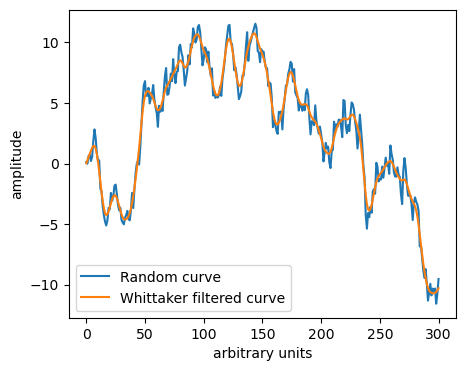

In [13]:
from pybaselines.whittaker import asls
# p=0.5 centres the "baseline" inside the data.
y_whit, params = asls(y, 10**1, p=0.5)

# Plot the results
plt.plot(y, label='Random curve')
plt.plot(y_whit, label='Whittaker filtered curve')
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.legend()
plt.show()

### Baseline estimation
- Used for baseline estimation/correction, the Whittaker smoother comes in many flavours.
- Basic version: Asymmetric Least Squares (PHM Eilers 2003) iteratively weights each point along the curve by:
    - $1-p$ if the curve is below the data,
    - $p$ if the curve is above the data.

In [14]:
# p<>0.5 moves the "baseline" towards outer regions of the data.

# Plot the results
def plot_asls(max_iter):
    y_whit_u, _ = asls(y, 10**4, p=0.98, max_iter=max_iter)
    y_whit_l, _ = asls(y, 10**4, p=0.02, max_iter=max_iter)
    plt.plot(y, label='Random curve')
    plt.plot(y_whit_u, label='Whittaker upper curve (p=0.99))')
    plt.plot(y_whit_l, label='Whittaker lower curve (p=0.01))')
    plt.xlabel('arbitrary units')
    plt.ylabel('amplitude')
    plt.legend()
    plt.show()
interact(plot_asls, max_iter=(0, 10, 1))

interactive(children=(IntSlider(value=5, description='max_iter', max=10), Output()), _dom_classes=('widget-int…

<function __main__.plot_asls(max_iter)>

### Exponential decay in weights
- Example of flavours: "Peaked Signal's Asymmetric Least Squares Algorithm"
- Documentation:  
  "Similar to the asymmetric least squares algorithm, but applies an exponential decay weighting to values greater than the baseline to allow using a higher p value to better fit noisy data."
- This version is not symmetric to up and down in the plot as we now in practice have $p\cdot e^{-(y_i-\hat{y}_i)/m}$ and $1-p$, so the code must be adapted to find "topline". ($m$ is a parameter controlling the exponential decay.)

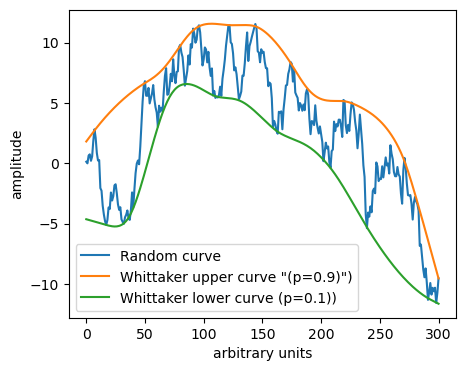

In [15]:
from pybaselines.whittaker import psalsa

y_whit_u, _ = psalsa(-y, 10**2, p=0.1)
y_whit_l, _ = psalsa(y, 10**2, p=0.1)
plt.plot(y, label='Random curve')
plt.plot(-y_whit_u, label='Whittaker upper curve "(p=0.9)")')
plt.plot(y_whit_l, label='Whittaker lower curve (p=0.1))')
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.legend()
plt.show()

## Exercise
- Fix the $p$ value at 0.01 and 0.99, respectively, for the upper (U) and lower curve (L).
- Let max_iter take it's default value, and assign the power of the smoother ($10^k$) to the slider ($k \in [0,10]$ with increments of 0.1).
- Make a side-by-side plot where the left one shows the same as the above, while the right one shows the data (D) after subtracting the lower curve (D-L) and dividing by the difference between the upper and lower curve (D-L)/(U-L).

## Resources
- [Signal-to-Noise Ratio in Python](https://saturncloud.io/blog/calculating-signaltonoise-ratio-in-python-with-scipy-v11/)
- [Wikipedia: Decibels (dB)](https://en.wikipedia.org/wiki/Decibel)
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)
- [medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html) and [median_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)
- [pybaselines.whittaker](https://pybaselines.readthedocs.io/en/latest/api/pybaselines/whittaker/index.html)
- [Wikipedia: Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)